In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from sklearn.preprocessing import StandardScaler
from sklearn.covariance import GraphicalLasso, GraphicalLassoCV
from scipy import stats
from matplotlib.colors import ListedColormap

import os
from dotenv import load_dotenv
os.chdir("..")

load_dotenv("globs.env")
tickers   = os.getenv("TICKERS").split(",")
media_dir = os.getenv("MEDIA_DIR")
data_dir  = os.getenv("DATA_DIR")

In [2]:
## Load data
X_df = pd.read_csv(data_dir + "/returns.csv").set_index("date").ffill() # handle NaN
X = StandardScaler().fit_transform(X_df.values)
n, p = X.shape
print(f"n x p:", (n, p))

n x p: (1222, 15)


### Part B

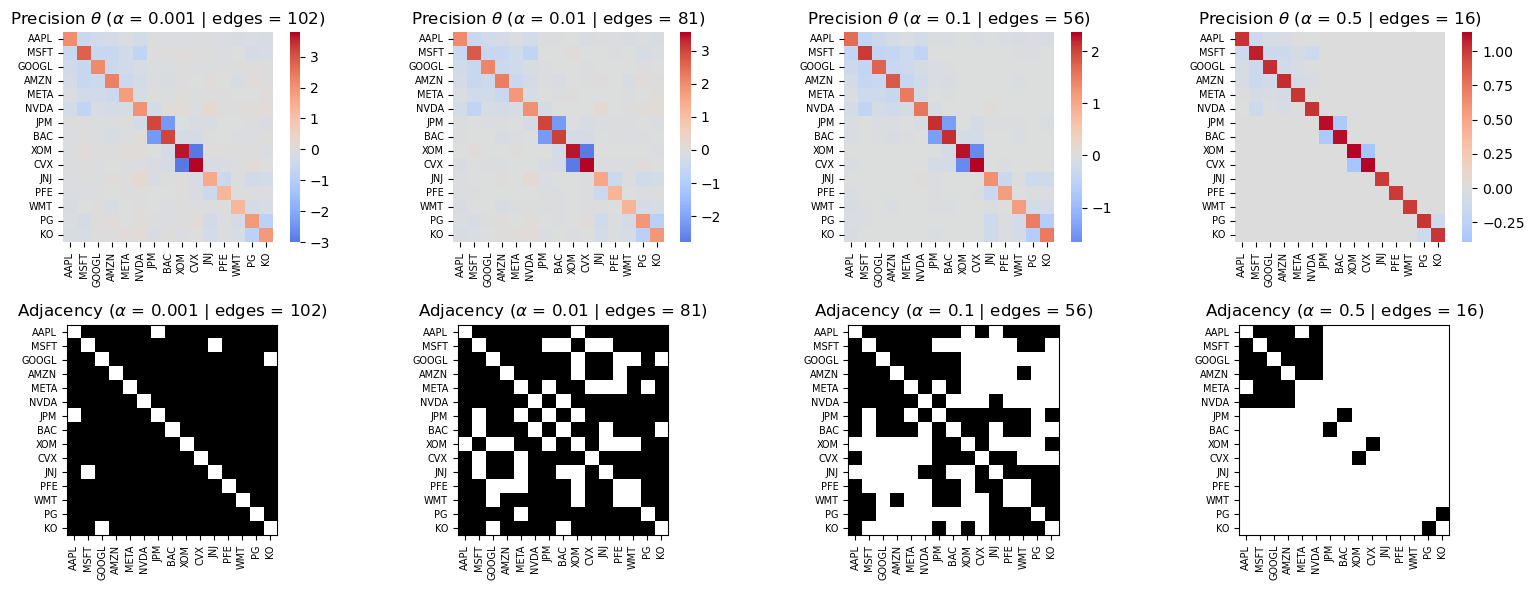

In [33]:
alphas = [0.001, 0.01, 0.1, 0.5]
thetas, adjs, titles = [], [], []

eps = 1e-6

for a in alphas:
    gl = GraphicalLasso(alpha=a, max_iter=2000)
    gl.fit(X)
    Theta = gl.precision_

    A = (np.abs(Theta) > eps).astype(int)
    np.fill_diagonal(A, 0)

    thetas.append(Theta)
    adjs.append(A)

    edges = int(np.sum(np.triu(A, 1)))
    titles.append(rf"$\alpha$ = {a:g} | edges = {edges}")

fig, axes = plt.subplots(2, len(alphas), figsize=(4 * len(alphas), 6))
cmap_bw = ListedColormap(["white", "black"])

for i, (Theta, A, ttl) in enumerate(zip(thetas, adjs, titles)):
    # Precision heatmap
    sns.heatmap(
        Theta, center=0, cmap="coolwarm", square=True,
        xticklabels=tickers, yticklabels=tickers,
        cbar_kws={"shrink": 1},
        ax=axes[0, i]
    )
    axes[0, i].set_title(rf"Precision $\theta$ ({ttl})")
    axes[0, i].tick_params(labelsize=7)
    for t in axes[0, i].get_xticklabels(): t.set_rotation(90)

    # adjacency
    axes[1, i].imshow(A, cmap=cmap_bw, vmin=0, vmax=1)
    axes[1, i].set_title(f"Adjacency ({ttl})")
    axes[1, i].set_xticks(range(p)); axes[1, i].set_yticks(range(p))
    axes[1, i].set_xticklabels(tickers, rotation=90, fontsize=7)
    axes[1, i].set_yticklabels(tickers, fontsize=7)

plt.tight_layout()
plt.show()

### work through code

In [12]:
glcv = GraphicalLassoCV(alphas=10, cv=5, max_iter=2000).fit(X)

Theta = glcv.precision_
alpha_star = glcv.alpha_

eps = 1e-8
A = (np.abs(Theta) > eps).astype(int)
np.fill_diagonal(A, 0)
A = np.maximum(A, A.T)

edges = int(np.sum(np.triu(A, 1)))

print(f"Chosen α (CV): {alpha_star:.6f}")
print("Edges:", edges)


Chosen α (CV): 0.020679
Edges: 72


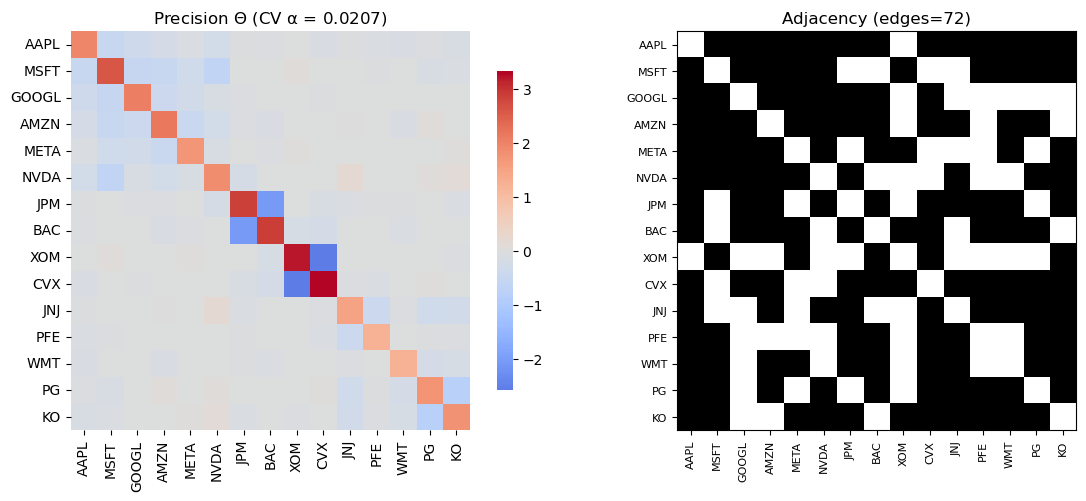

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(
    Theta, center=0, cmap="coolwarm", square=True,
    xticklabels=tickers, yticklabels=tickers,
    cbar_kws={"shrink": 0.8},
    ax=axes[0]
)
axes[0].set_title(rf"Precision $\Theta$ (CV α = {alpha_star:.3g})")
for t in axes[0].get_xticklabels(): t.set_rotation(90)

# adjacency
axes[1].imshow(A, cmap=ListedColormap(["white", "black"]), vmin=0, vmax=1)
axes[1].set_title(f"Adjacency (edges={edges})")

axes[1].set_xticks(range(p)); axes[1].set_yticks(range(p))
axes[1].set_xticklabels(tickers, rotation=90, fontsize=8)
axes[1].set_yticklabels(tickers, fontsize=8)

plt.tight_layout()
plt.show()


In [14]:
def gaussian_copula_transform(X):
    Xn = np.zeros_like(X)
    for j in range(X.shape[1]):
        ranks = stats.rankdata(X[:, j], method="average")
        u = (ranks - 0.5) / len(ranks)
        Xn[:, j] = stats.norm.ppf(u)
    return Xn

X_gc = gaussian_copula_transform(X_df.values)
X_gc = StandardScaler().fit_transform(X_gc)


In [15]:
gl_gc = GraphicalLassoCV(alphas=10, cv=5, max_iter=2000).fit(X_gc)
Theta_gc = gl_gc.precision_
alpha_star_cop = gl_gc.alpha_

eps = 1e-8
A_gc = (np.abs(Theta_gc) > eps).astype(int)
np.fill_diagonal(A_gc, 0)
A_gc = np.maximum(A_gc, A_gc.T)

edges_gc = int(np.sum(np.triu(A_gc, 1)))

print(f"Chosen α (copula CV): {alpha_star_cop:.6f}")
print("Edges:", edges_gc)


Chosen α (copula CV): 0.014279
Edges: 81


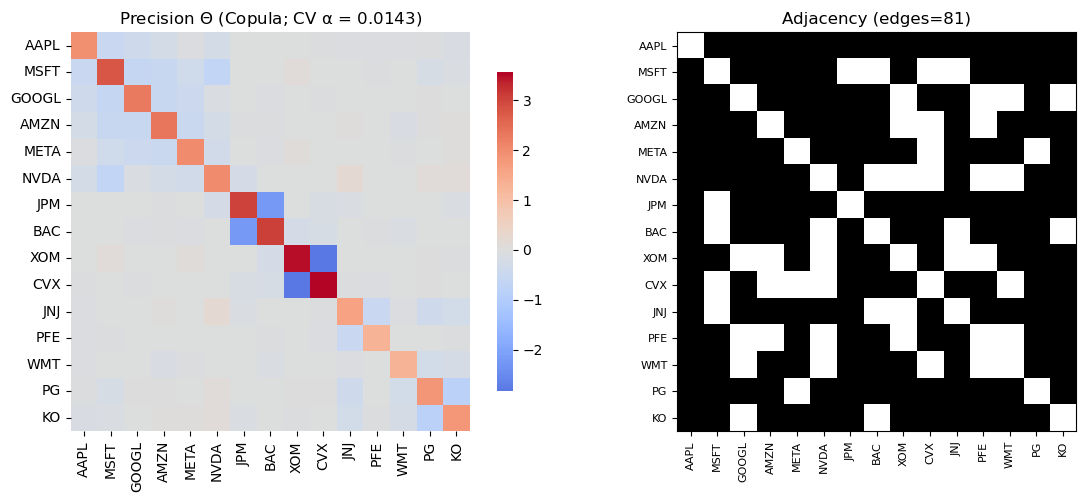

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(
    Theta_gc, center=0, cmap="coolwarm", square=True,
    xticklabels=tickers, yticklabels=tickers,
    cbar_kws={"shrink": 0.8},
    ax=axes[0]
)
axes[0].set_title(rf"Precision $\Theta$ (Copula; CV α = {alpha_star_cop:.3g})")
for t in axes[0].get_xticklabels(): t.set_rotation(90)

axes[1].imshow(A_gc, cmap=ListedColormap(["white", "black"]), vmin=0, vmax=1)
axes[1].set_title(f"Adjacency (edges={edges_gc})")

axes[1].set_xticks(range(p)); axes[1].set_yticks(range(p))
axes[1].set_xticklabels(tickers, rotation=90, fontsize=8)
axes[1].set_yticklabels(tickers, fontsize=8)

plt.tight_layout()
plt.show()
